In [4]:
import os
from os import path

import pandas as pd
import json

from Bio import Phylo
from Bio.Phylo.TreeConstruction import DistanceCalculator
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor
from Bio import AlignIO

import networkx as nx

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as clr
%matplotlib inline

In [5]:
sim_id = 200
pathogen_id = 35

In [8]:
# Configuration

data_folder = path.join("data", str(sim_id))
output_folder = path.join("output", str(sim_id))
if not path.exists(output_folder):
    os.makedirs(output_folder)

style = {}
style["bbox"] = (1200, 800)
style["margin"] = 15
style["vertex_size"] = 7
style["vertex_frame_width"] = 0
style["edge_arrow_size"] = 0.6
style["edge_arrow_width"] = 0.6
style["edge_curved"] = False

In [9]:
# Load the data

all_users = pd.read_csv(path.join(data_folder, "participants.csv"))
all_sequences = pd.read_csv(path.join(data_folder, "sequences.csv"))
all_mutations = pd.read_csv(path.join(data_folder, "mutations.csv"))

users = all_users[all_users["sim_id"] == sim_id]
ref_seq = list(all_sequences[all_sequences["pathogen_id"] == pathogen_id]["sequence"].values[0])

In [47]:
# Save all the recorded sequences

def apply_delta(seq, delta):
    for k in delta.keys():
        pos = int(k)
        nt0, nt1 = delta[k].split('-')
        seq[pos] = nt1

def add_sequence(uid, mid, pmid, seq, lines):
    sid = seq_ids[-1]
    seq_ids.append(sid + 1)    
    seq_id = str(sid).zfill(max_seq_id_len)
    seq_meta[seq_id] = [uid, pmid, mid]    
    lines += [">" + seq_id]
    lines += [''.join(seq)]

def get_prev_seq(p_mut_id, transmissions, fasta_lines):
    if p_mut_id == 0:
        return ref_seq.copy()
    else:
        prev_mutation = mutations[mutations["id"] == p_mut_id]
        puser_id = prev_mutation["user_id"].values[0]
        prev_seq = list(prev_mutation["sequence"].values[0])
        if prev_seq:
            return prev_seq
        else:
            if prev_mutation["id"].values[0] != p_mut_id:
                print("Error, inconsistent mutation ID for", p_mut_id)
                return []
            pp_mut_id = prev_mutation["prev_mutation_id"].values[0]
            prev_seq = get_prev_seq(pp_mut_id, transmissions, fasta_lines)
            if not prev_seq: return []
            apply_delta(prev_seq, json.loads(prev_mutation["delta"].values[0]))
            prev_mutation["sequence"].values[0] = prev_seq
            add_seq = True
            if pathogen_id < pp_mut_id:
                t = (pp_mut_id - pathogen_id - 1, p_mut_id - pathogen_id - 1)
                if not t in transmissions:
                    transmissions += [t]
                else:
                    print("Warning: duplicated transmission", str(pp_mut_id) + "-" + str(p_mut_id))
                    add_seq = False
            if add_seq: add_sequence(puser_id, p_mut_id, pp_mut_id, prev_seq, fasta_lines)
            return prev_seq.copy()

mutations = all_mutations[all_mutations["sim_id"] == sim_id]
mutations = mutations.assign(sequence='')
mutations.sort_values(by=['id'], inplace=True)

print(''.join(ref_seq))
print(len(mutations))

max_seq_id_len = len(str(len(mutations)))
seq_ids = [1]
seq_meta = {}

transmissions = []
fasta_lines = []
for idx in mutations.index:
    mut_id = mutations["id"][idx]
    p_mut_id = mutations["prev_mutation_id"][idx]
    seq = mutations["sequence"][idx]
    user_id = mutations["user_id"][idx]

    if mut_id == p_mut_id:
        # This is to handle an intermal AMR mutation triggered by antibiotic use
        # print("AMR mutation")
        p_mut_id = 0
    
    if seq: continue
    prev_seq = get_prev_seq(p_mut_id, transmissions, fasta_lines)
    if not prev_seq: 
        print("Error, cannot resolve sequence for mutation", p_mut_id)
        continue
    apply_delta(prev_seq, json.loads(mutations["delta"][idx]))
    mutations.at[idx, "sequence"] = prev_seq
    add_seq = True
    if pathogen_id < p_mut_id:
        t = (p_mut_id, mut_id)
        if not t in transmissions:
            transmissions += [t]
        else:
            print("Warning: duplicated transmission", str(p_mut_id) + "-" + str(mut_id))
            add_seq = False
    if add_seq: add_sequence(user_id, mut_id, p_mut_id, prev_seq, fasta_lines)

print("Saving FASTA file")
fasta_fn = path.join(output_folder, "sequences.fasta")
with open(fasta_fn, 'w') as f:
    for line in fasta_lines:
        f.write(line + '\n')

print("Saving MSA file")
# All sequences from the sim align perfectly since they only differ in point mutations
# from one another.
phy_fn = path.join(output_folder, "msa.phy")
with open(phy_fn, 'w') as f:
    f.write(str(int(len(fasta_lines)/2)) + " " + str(len(ref_seq)) + '\n')
    for i in range(1, len(fasta_lines), 2):
        name = fasta_lines[i - 1]
        seq = fasta_lines[i]
        f.write(name[1:].ljust(max_seq_id_len + 2) + seq + '\n')

aaatttaggtcttaaggccgctcctgtttcaaatcaagtgatccaaagagatcgttatgctcaggttatttctgctattgcgattttagcttcaagttgtgagcaaatcgctgtagccataagacattttcaaagaactgaagtttatgaggctgaggagtattttagtgtaggacaaaaaggaagttcagctatgccacataaaagaaatcctgttttaagtgaaaatatcacaggactttgtcgtgtgcttagatcttttgtaactccagctttggaaaatgttgcactttggcatgaaagagatatatctcattctagtgttgaaagatttattttgcctgatgctt
77
Saving FASTA file
Saving MSA file


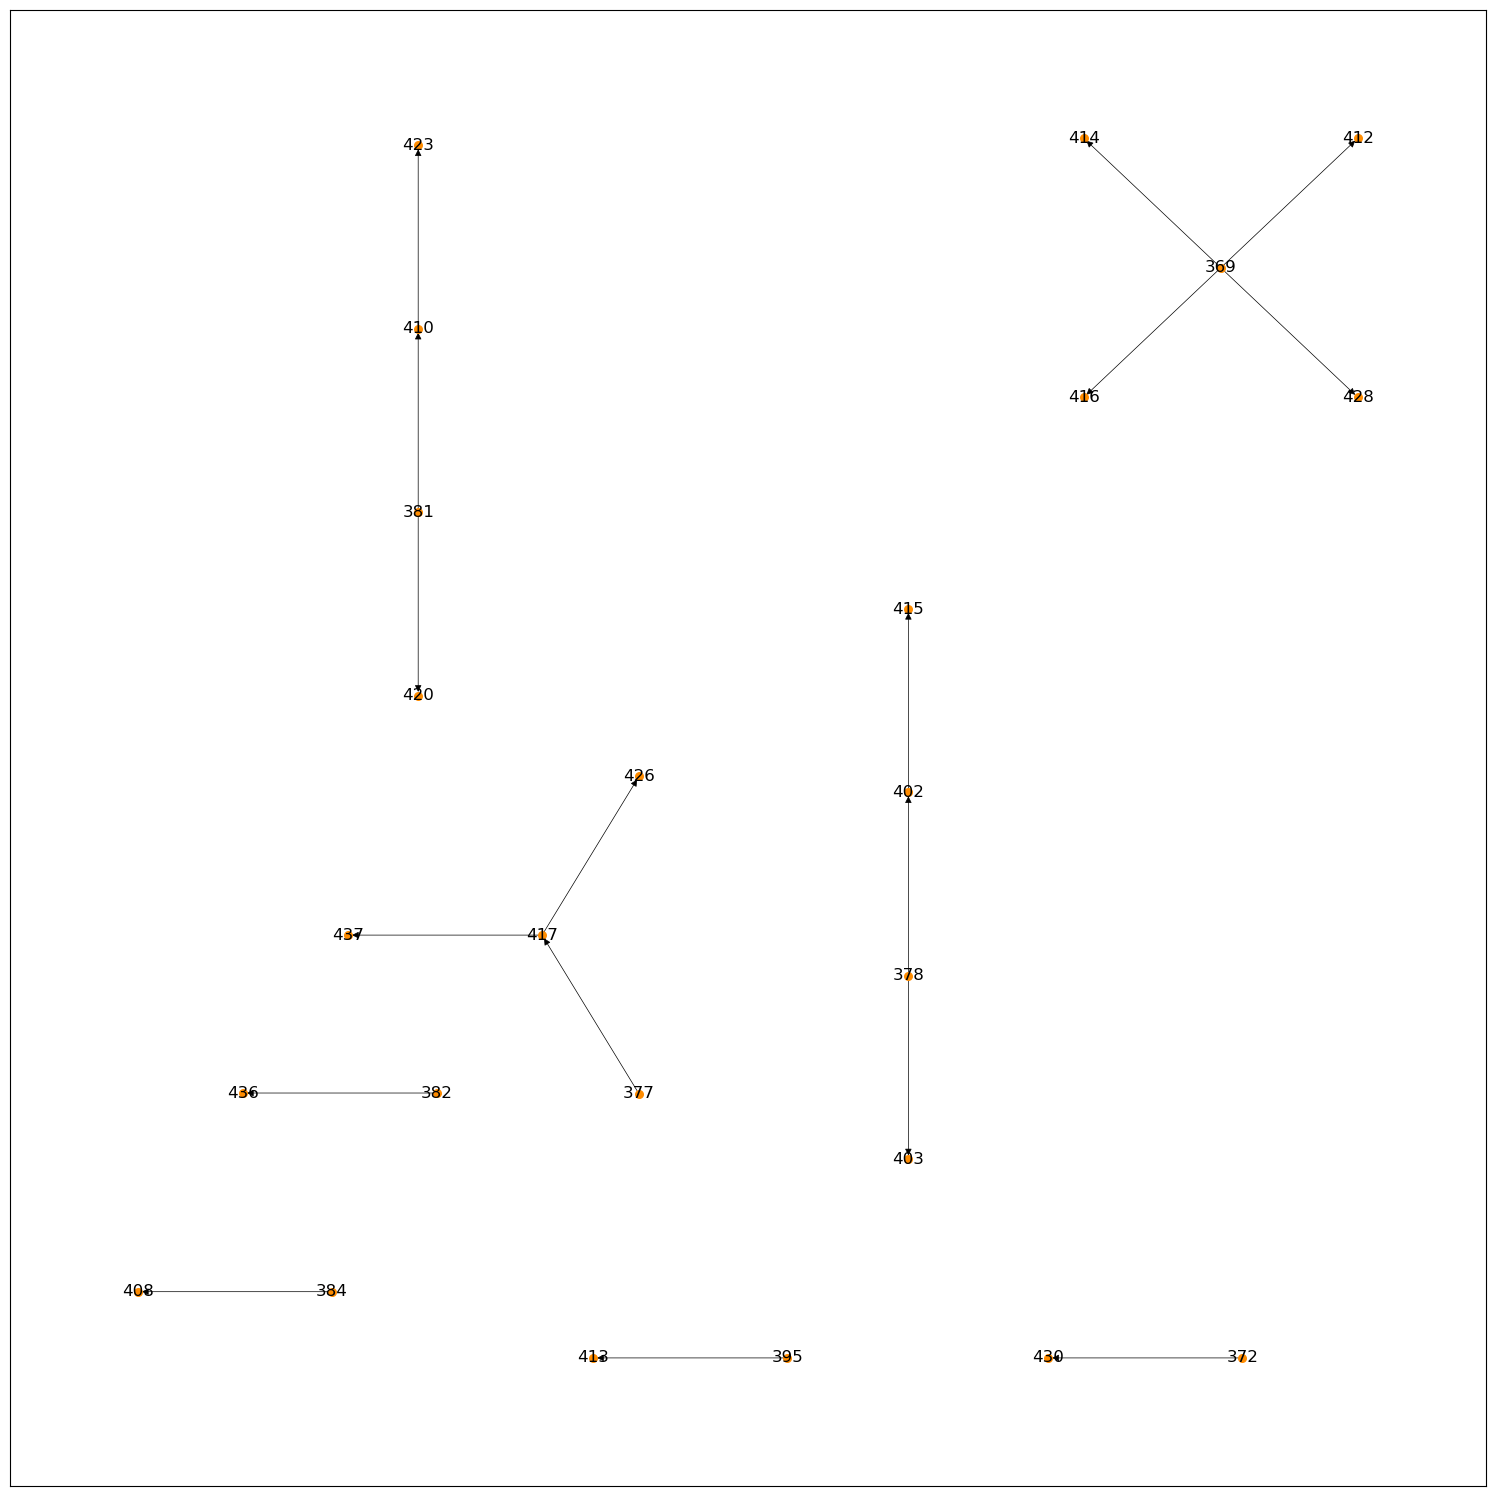

In [48]:
# Create network of transmissions from sequence data

g = nx.DiGraph(transmissions)

pos = nx.nx_agraph.graphviz_layout(g, prog='twopi')
plt.figure(figsize=(15, 15))
nx.draw_networkx(g, pos, with_labels=True, node_color='darkorange', node_size=30, width=0.5, alpha=1)
plt.tight_layout()
plt.savefig(path.join(output_folder, 'transmission-tree.png'))
plt.show()

In [50]:
# Generate phylogenetic tree from the sequences
# (could also do online using the Fasta file in https://www.ebi.ac.uk/Tools/msa/clustalo/)

print("Generating phylogenetic tree")

aln = AlignIO.read(phy_fn, 'phylip')

calculator = DistanceCalculator('identity')
dm = calculator.get_distance(aln)

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

tree_fn = path.join(output_folder, "tree.dnd")
Phylo.write(tree, tree_fn, "newick")

Generating phylogenetic tree


1

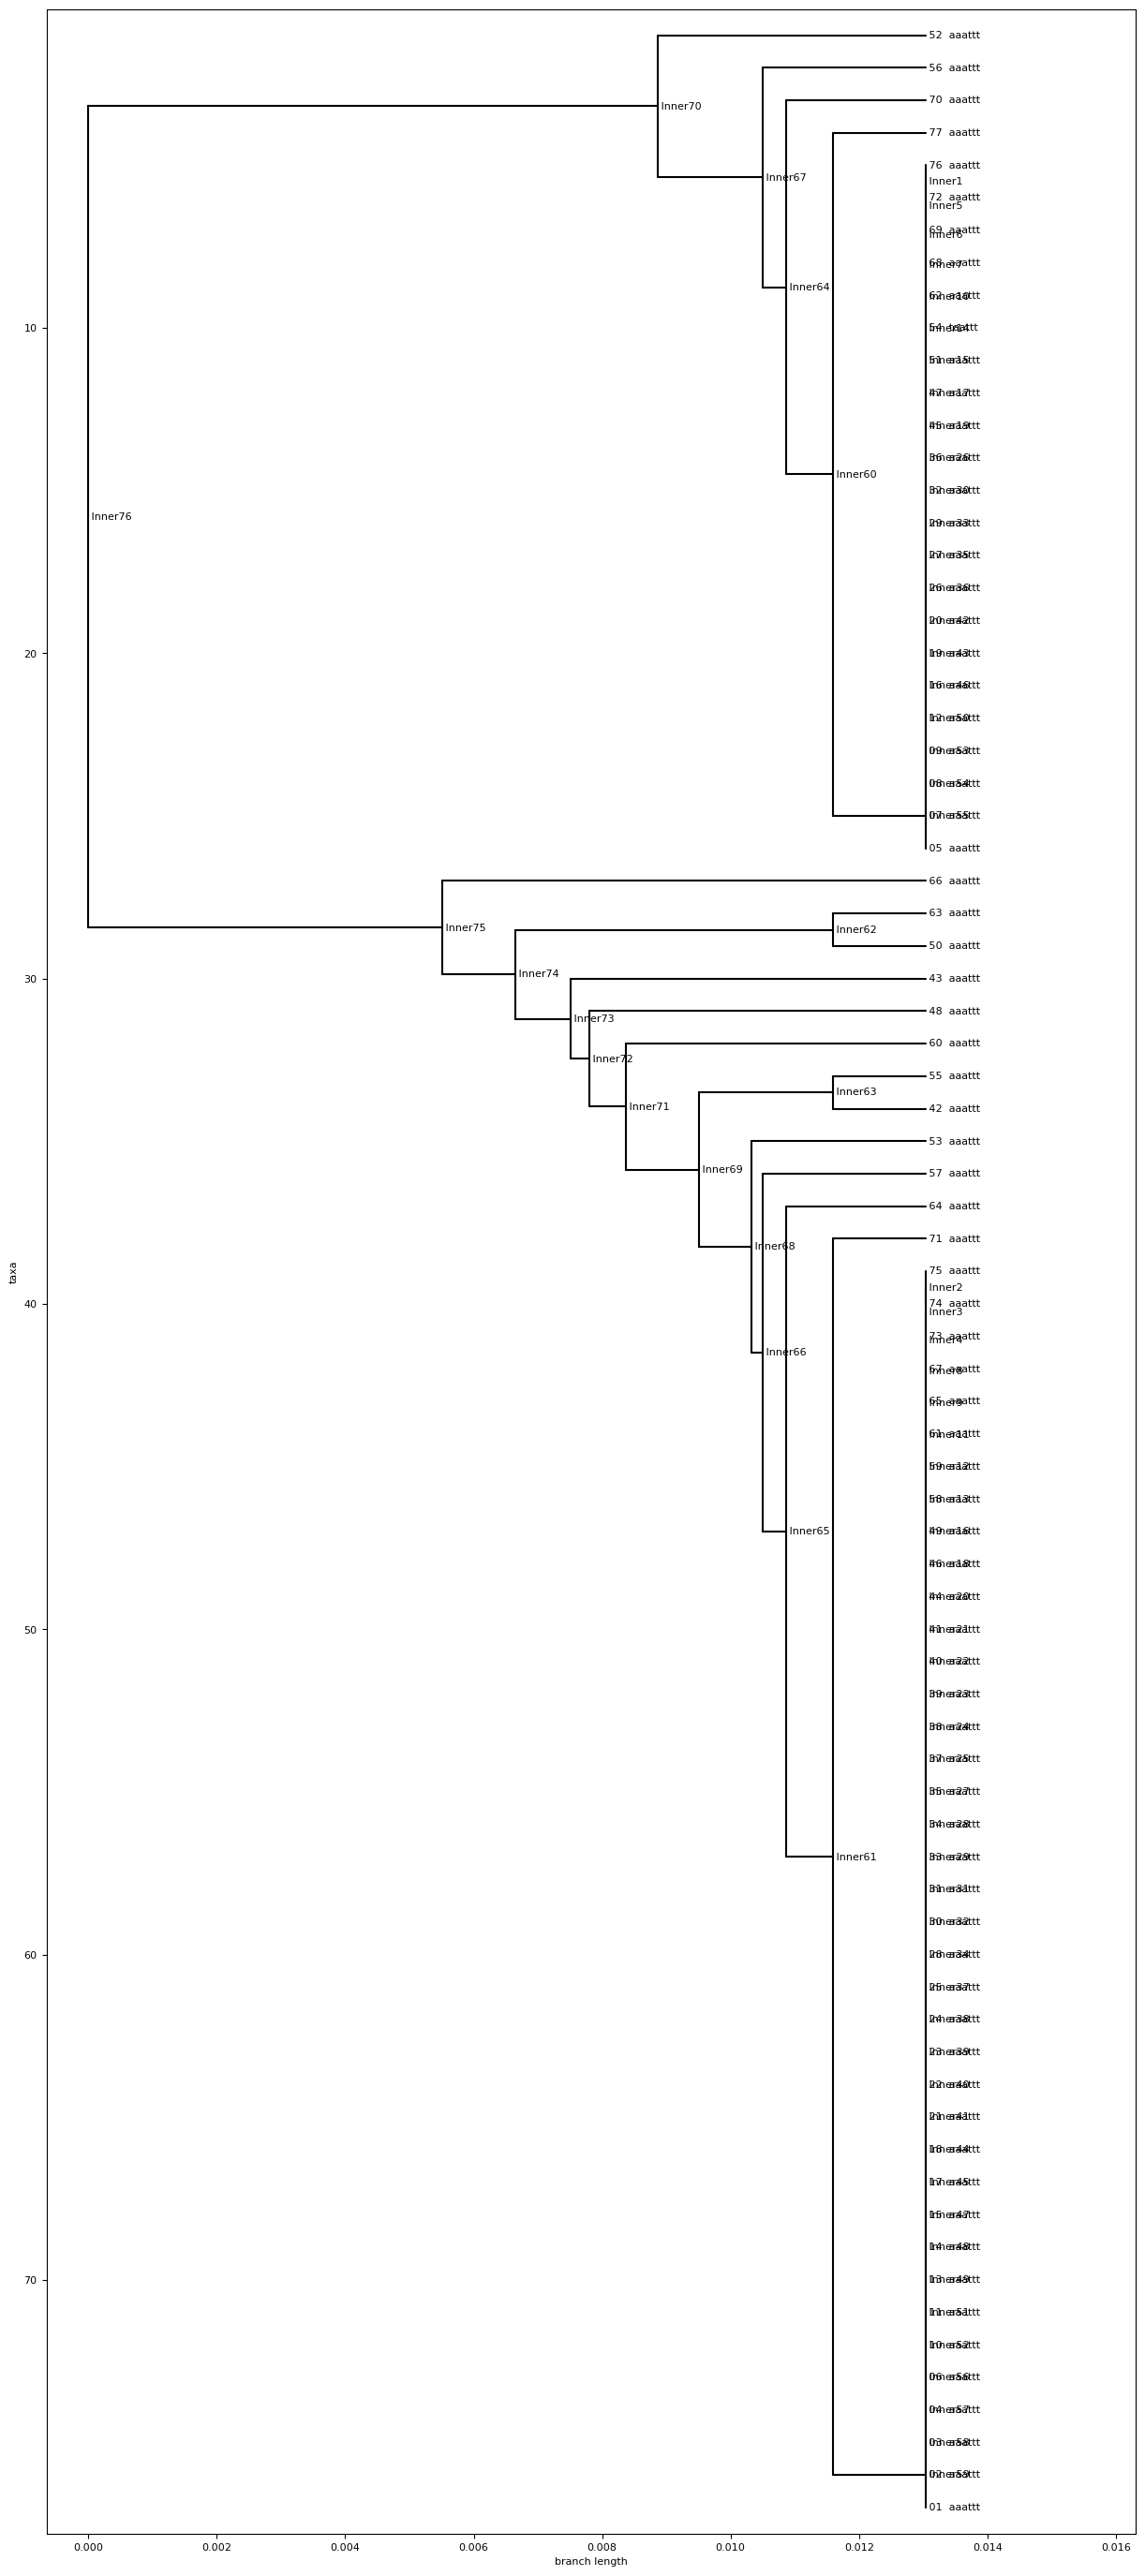

Saving tree image with linear layout


In [51]:
img_linear_fn = path.join(output_folder, "tree-linear.pdf")
img_radial_fn = path.join(output_folder, "tree-radial.pdf")

matplotlib.rc('font', size=8)

fig, ax = plt.subplots(figsize=(15, 35), dpi=100)
Phylo.draw(tree, axes=ax, do_show=False)
plt.show()

print("Saving tree image with linear layout")
Phylo.draw(tree, axes=ax, do_show=False)
fig.tight_layout()
fig.savefig(img_linear_fn, dpi=100)

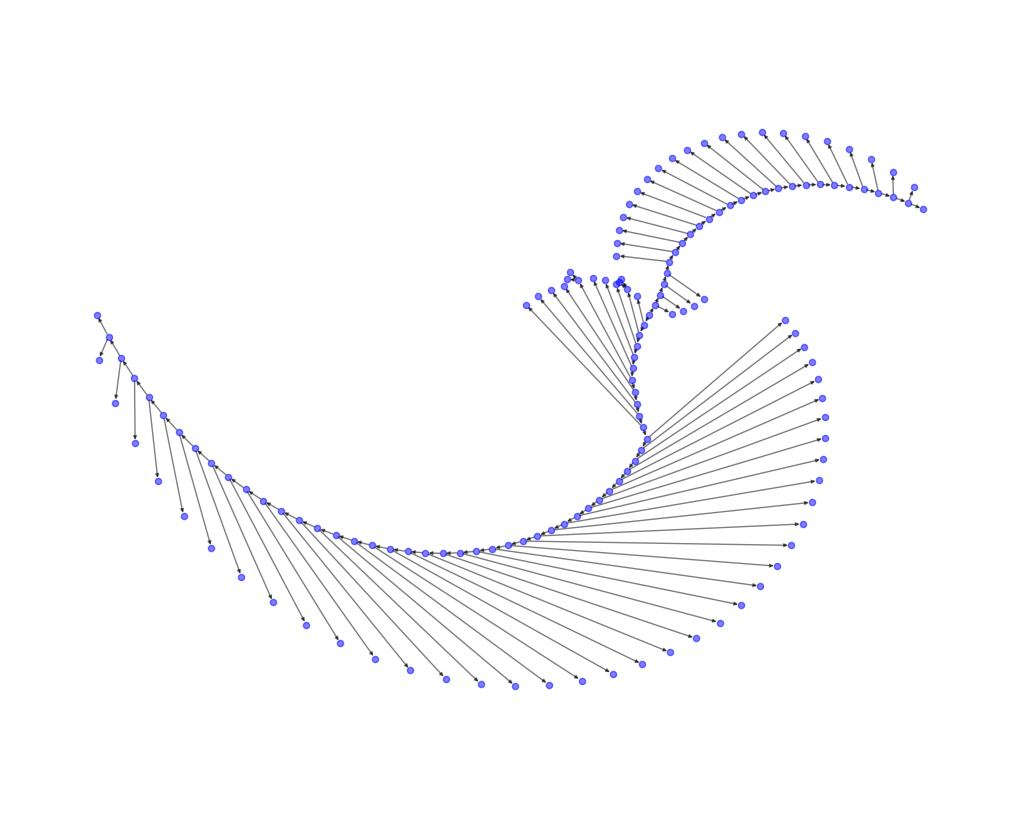

Saving tree image with radial layout


In [52]:
net = Phylo.to_networkx(tree)
pos = nx.nx_agraph.graphviz_layout(net, prog="twopi", args="")
fig = plt.figure(figsize=(10, 8))
nx.draw(net, pos, node_size=20, arrowsize=5, alpha=0.5, node_color="blue", with_labels=False)
plt.axis("equal")
plt.show()

print("Saving tree image with radial layout")
fig.savefig(img_radial_fn, dpi=100)